# Structural MRI Data Preprocessing: CAT12 Pipeline and AnatCL Performance Evaluation via Linear Regression with K-Fold Cross-Validation

## Libraries and AnatCL model

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import matplotlib.pyplot as plt
from anatcl import AnatCL
import torch.nn as nn
import torch.optim as optim
import os, random, numpy as np, torch

import glob
import subprocess
import json
from pathlib import Path
import time

## Paths

In [ ]:
base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids"
subject_list_path = os.path.join(base_dir, "female_p_ages.txt")
subject_list = os.path.join(base_dir, "female_ids_with_T1w.txt")
output_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/preprocessed_output"
container_image = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"
boutiques_descriptor = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/descriptors/cat12_prepro.json"

print("CAT12 + Smoothing Pipeline")
print("-" * 100)
print(f"Base directory: {base_dir}")
print(f"Subject list (with ages): {subject_list_path}")
print(f"Subject list: {subject_list}")
print(f"Output directory: {output_dir}")
print(f"Container image: {container_image}")
print(f"Boutiques descriptor: {boutiques_descriptor}")
print()

## Visualizing Participant Raw T1w Image (Example) 

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

t1w_data = []
count = 0

with open(subject_list, 'r') as f:
    for line in f:
        subject_id = line.strip()
        subject_dir = os.path.join(base_dir, subject_id)

        if not os.path.exists(subject_dir):
            continue
            
        try:
            ses_folders = [f for f in os.listdir(subject_dir) if f.startswith("ses-")]
            if not ses_folders:
                continue
        except:
            continue

        found_t1 = False
        for ses in ses_folders:
            anat_path = os.path.join(subject_dir, ses, "anat")
            if not os.path.isdir(anat_path):
                continue

            for file in os.listdir(anat_path):
                if "T1w" in file and file.endswith(".nii"):
                    t1_path = os.path.join(anat_path, file)
                    output_subdir = os.path.join(output_dir, subject_id)
                    os.makedirs(output_subdir, exist_ok=True)
                    
                    t1w_data.append({
                        'subject_id': subject_id,
                        'input_file': t1_path,
                        'output_dir': output_subdir
                    })
                    count += 1
                    found_t1 = True
                    break

            if found_t1:
                break

first_subject = t1w_data[0]
img = nib.load(first_subject['input_file'])
data = img.get_fdata()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(data[data.shape[0]//2, :, :], cmap='gray')
plt.title(f"Sagittal: {first_subject['subject_id']}")

plt.subplot(1, 3, 2)
plt.imshow(data[:, data.shape[1]//2, :], cmap='gray')
plt.title("Coronal")

plt.subplot(1, 3, 3)
plt.imshow(data[:, :, data.shape[2]//2], cmap='gray')
plt.title("Axial")
plt.show()

## Preprocessing

In [ ]:
%load_ext slurm_magic

In [ ]:
#Downloading the Container

!module load apptainer

from boutiques import bosh
import boutiques.descriptor2func

bosh(["exec", "prepare", boutiques_descriptor, "--imagepath", "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"])
cat12 = boutiques.descriptor2func.function(boutiques_descriptor)


In [ ]:
%%writefile ~/links/projects/rrg-glatard/arelbaha/hbn_bids/cat12_preprocessing.py

import os
import glob
import boutiques
from boutiques import bosh
from boutiques.descriptor2func import function

#Downloading Container Part + Paths
boutiques_descriptor = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/descriptors/cat12_prepro.json"
base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids"
output_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/preprocessed_output"

bosh(["exec", "prepare", boutiques_descriptor, "--imagepath", "/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif"])
cat12 = boutiques.descriptor2func.function(boutiques_descriptor)

#Task ID Extraction
t1_nii_files = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "sub-*_T1w.nii"))
print(f"Found {len(t1_nii_files)} T1w files.")

task_id = int(os.environ["SLURM_ARRAY_TASK_ID"])

if task_id >= len(t1_nii_files) or task_id < 0:
    print(f"SLURM_ARRAY_TASK_ID={task_id} out of range")
    exit(1)

input_file = t1_nii_files[task_id]

path_parts = input_file.split(os.sep)
subject_id = next((part for part in path_parts if part.startswith("sub-")), None)

if subject_id is None:
        print(f"Could not find subject ID in path: {input_file}")
        exit(1)

filename = os.path.basename(input_file)

subject_output_dir = os.path.join(output_dir, subject_id)
os.makedirs(subject_output_dir, exist_ok=True)

print(f"Processing SLURM_ARRAY_TASK_ID ={task_id} -> file: {filename} (subject: {subject_id})")

result = cat12('--imagepath=/home/arelbaha/links/projects/rrg-glatard/arelbaha/containers/cat12_prepro.sif', 
                   input_file=input_file, 
                   output_dir=subject_output_dir)

result_dict = vars(result)
print("Available result keys:", result_dict.keys())
print("\nExit code:", result_dict.get("exit_code"))
print("\nStdout:\n", result_dict.get ("stdout" ))
print("\nStderr:\n", result_dict.get ("stderr"))
print("\nOutput files:\n", result_dict.get("output_files"))

In [ ]:
%%sbatch --array=761-860
#!/bin/bash
#SBATCH --job-name=CAT12_preproc
#SBATCH --account=rrg-glatard
#SBATCH --mem=8G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=CAT12_preproc_%A_%a.out
#SBATCH --error=CAT12_preproc_%A_%a.err
#SBATCH --time=1:0:0

source ~/.venvs/jupyter_py3/bin/activate

module load apptainer

cd ~/links/projects/rrg-glatard/arelbaha/hbn_bids #Location of preprocessing data and script

echo "Running task ID: $SLURM_ARRAY_TASK_ID"

python cat12_preprocessing.py

## Checking Preprocessed Data 

In [ ]:
data = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "mri", "s6mwp1sub-*_T1w.nii"))

first_subject = data[0]

img = nib.load(first_subject)
data = img.get_fdata()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(data[data.shape[0] // 2, :, :], cmap='gray')
plt.title(f"Sagittal: sub-{subject_id}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(data[:, data.shape[1] // 2, :], cmap='gray')
plt.title("Coronal")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
plt.title("Axial")
plt.axis('off')

plt.tight_layout()
plt.show()

## Using Preprocessed Data and Linear Probing

In [ ]:
%%writefile ~/links/projects/rrg-glatard/arelbaha/hbn_bids/brain_age_prediction.py

import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import nibabel as nib
import matplotlib.pyplot as plt
from anatcl import AnatCL
from sklearn.model_selection import train_test_split, KFold

#Get Ages

base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids"
subject_list_path = os.path.join(base_dir, "female_p_ages.txt")

data = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "mri", "s6mwp1sub-*_T1w.nii"))

id_age_dict = {}
with open(subject_list_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            sid, age = parts
            id_age_dict[sid] = float(age)

matched_subjects = []
ages = []

for i in data:
    path_parts = i.split(os.sep)
    sub_folder = next((part for part in path_parts if part.startswith("sub-")), None)
    if sub_folder:
        subject_id = sub_folder.replace("sub-", "")
        if subject_id in id_age_dict:
            matched_subjects.append(i)
            ages.append(id_age_dict[subject_id])

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

class CAT12VBMDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = nib.load(self.data[idx]).get_fdata()
        if self.transform:
            img = self.transform(img)
        img = img.unsqueeze(0)
        if self.labels is None:
            return img, os.path.basename(self.data[idx])
        return img, torch.tensor(self.labels[idx], dtype=torch.float32)

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x.copy()).float()),
    transforms.Normalize(mean=0.0, std=1.0),
])

device = "cuda" if torch.cuda.is_available() else "cpu"

# Encoder (frozen)
path = "/home/arelbaha/.venvs/jupyter_py3/bin/fold0.pth"
encoder = AnatCL(descriptor="global", fold=0, pretrained=False).to(device).eval()
checkpoint = torch.load(path, map_location=device, weights_only=False)
encoder.backbone.load_state_dict(checkpoint['model'])

for p in encoder.parameters():
    p.requires_grad = False

#Extracting Embeddings
ds = CAT12VBMDataset(data, ages, transform)
dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)

with torch.no_grad():
    X, y = [], []
    for vol, label in dl:
        vol = vol.to(device)
        feat = encoder(vol)
        X.append(feat.squeeze(0).cpu())
        y.append(label.squeeze(0).cpu())

X = torch.cat(X)
y = torch.cat(y)

N = len(X)
test_size = int(0.1 * N)
indices = np.arange(N)
np.random.seed(SEED)
np.random.shuffle(indices)

test_indices = indices[:test_size]
cv_indices = indices[test_size:]

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

alphas = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
num_epochs = 300
batch_size = 32

class BrainAgeHead(nn.Module):
    def __init__(self, input_dim=512):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x).squeeze(1)

criterion = nn.L1Loss()

val_mae_results = {alpha: [] for alpha in alphas}

for fold, (train_idx_rel, val_idx_rel) in enumerate(kf.split(cv_indices)):
    print(f"Fold {fold+1}")
    
    train_idx = cv_indices[train_idx_rel]
    val_idx = cv_indices[val_idx_rel]
    
    for alpha in alphas:
        n_train_downsample = int(alpha * len(train_idx))
        np.random.seed(SEED)
        train_idx_downsampled = np.random.choice(train_idx, size=n_train_downsample, replace=False)

        train_sampler = SubsetRandomSampler(train_idx_downsampled)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=val_sampler)

        model = BrainAgeHead().to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        model.train()
        for epoch in range(num_epochs):
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        val_mae = np.mean(val_losses)
        val_mae_results[alpha].append(val_mae)
        print(f"  Alpha {alpha}: Val MAE = {val_mae:.4f}")

avg_val_mae = {alpha: np.mean(val_mae_results[alpha]) for alpha in alphas}
best_alpha = min(avg_val_mae, key=avg_val_mae.get)
print(f"Best alpha: {best_alpha} with avg val MAE: {avg_val_mae[best_alpha]:.4f}")

n_train_full = int(best_alpha * len(cv_indices))
np.random.seed(SEED)
train_full_idx = np.random.choice(cv_indices, size=n_train_full, replace=False)
train_full_sampler = SubsetRandomSampler(train_full_idx)
full_train_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=train_full_sampler)

final_model = BrainAgeHead().to(device)
optimizer = optim.Adam(final_model.parameters(), lr=1e-3)

final_model.train()
for epoch in range(num_epochs):
    for xb, yb in full_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()


test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, sampler=test_sampler)

final_model.eval()
test_losses = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = final_model(xb)
        loss = criterion(preds, yb)
        test_losses.append(loss.item())

test_mae = np.mean(test_losses)
print(f"Test MAE with best alpha {best_alpha}: {test_mae:.4f}")

y_test = y[test_indices].cpu()
preds_test = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = final_model(xb)
        preds_test.append(preds.cpu())
preds_test = torch.cat(preds_test)

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=brain_age_prediction
#SBATCH --account=rrg-glatard
#SBATCH --mem=16G
#SBATCH --cpus-per-task=4
#SBATCH --nodes=1
#SBATCH --output=result_age.out
#SBATCH --error=result_age.err
#SBATCH --time=1:00:00

source ~/.venvs/jupyter_py3/bin/activate
cd ~/links/projects/rrg-glatard/arelbaha/hbn_bids
python brain_age_prediction.py

## Performance Analysis

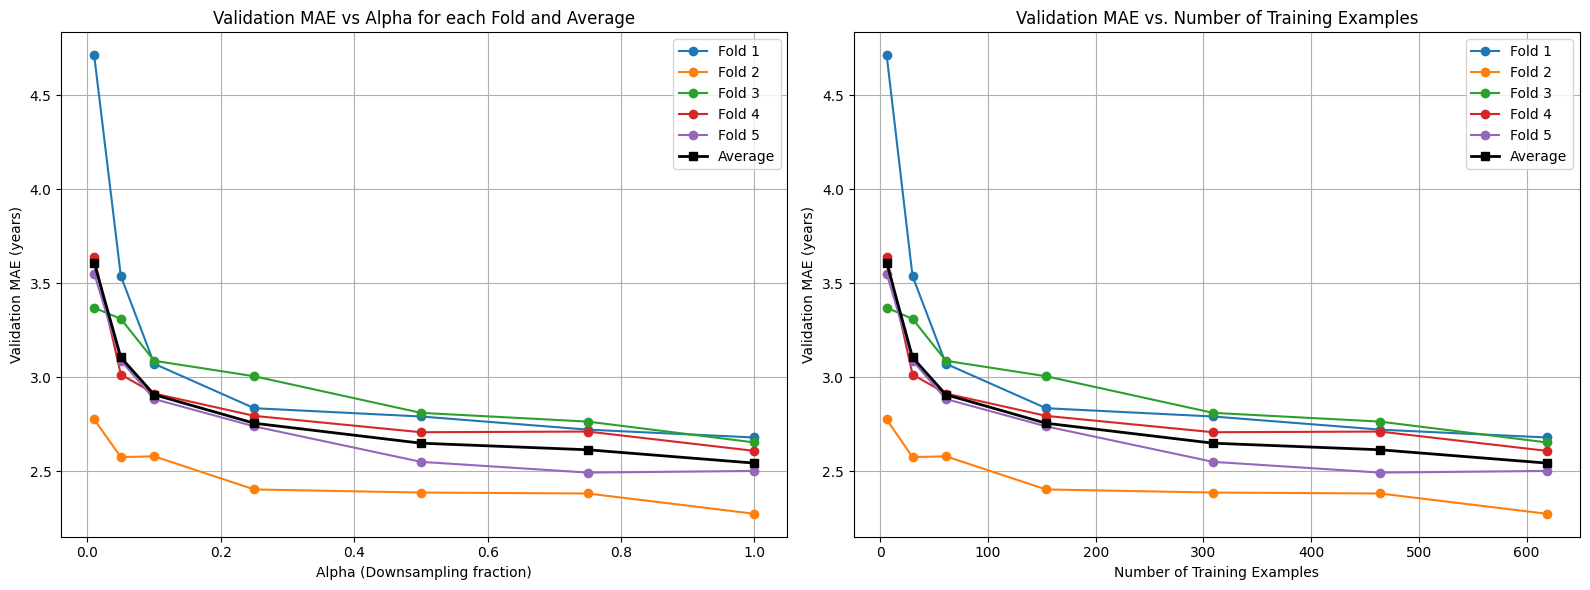

Best alpha: 1.0 with avg val MAE: 2.5439
Test MAE with best alpha 1.0: 2.009

Approximate number of training examples per alpha:
Alpha 0.01: 6 examples
Alpha 0.05: 30 examples
Alpha 0.1: 61 examples
Alpha 0.25: 154 examples
Alpha 0.5: 309 examples
Alpha 0.75: 464 examples
Alpha 1.0: 619 examples


In [40]:
import matplotlib.pyplot as plt
import numpy as np

fold_maes = {
    1: {0.01: 4.7128, 0.05: 3.5387, 0.1: 3.0722, 0.25: 2.8359, 0.5: 2.7918, 0.75: 2.7220, 1.0: 2.6802},
    2: {0.01: 2.7762, 0.05: 2.5759, 0.1: 2.5800, 0.25: 2.4039, 0.5: 2.3874, 0.75: 2.3824, 1.0: 2.2744},
    3: {0.01: 3.3704, 0.05: 3.3110, 0.1: 3.0881, 0.25: 3.0058, 0.5: 2.8112, 0.75: 2.7647, 1.0: 2.6538},
    4: {0.01: 3.6374, 0.05: 3.0151, 0.1: 2.9139, 0.25: 2.7951, 0.5: 2.7082, 0.75: 2.7117, 1.0: 2.6090},
    5: {0.01: 3.5519, 0.05: 3.0892, 0.1: 2.8847, 0.25: 2.7393, 0.5: 2.5507, 0.75: 2.4935, 1.0: 2.5023},
}

alphas = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
folds = sorted(fold_maes.keys())

val_maes_per_alpha = {alpha: [] for alpha in alphas}
for fold in folds:
    for alpha in alphas:
        val_maes_per_alpha[alpha].append(fold_maes[fold][alpha])

avg_val_maes = {alpha: np.mean(val_maes_per_alpha[alpha]) for alpha in alphas}

N = 859
test_size = int(0.1 * N)
cv_indices_size = N - test_size 
train_idx_size = int(cv_indices_size * (4/5))
train_examples_per_alpha = {alpha: int(alpha * train_idx_size) for alpha in alphas}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for fold in folds:
    maes = [fold_maes[fold][alpha] for alpha in alphas]
    ax1.plot(alphas, maes, marker='o', label=f'Fold {fold}')

avg_maes = [avg_val_maes[alpha] for alpha in alphas]
ax1.plot(alphas, avg_maes, marker='s', color='black', linewidth=2, label='Average')
ax1.set_xlabel("Alpha (Downsampling fraction)")
ax1.set_ylabel("Validation MAE (years)")
ax1.set_title("Validation MAE vs Alpha for each Fold and Average")
ax1.legend()
ax1.grid(True)

x_vals = [train_examples_per_alpha[alpha] for alpha in alphas]
for fold in folds:
    maes = [fold_maes[fold][alpha] for alpha in alphas]
    ax2.plot(x_vals, maes, marker='o', label=f'Fold {fold}')

ax2.plot(x_vals, avg_maes, marker='s', color='black', linewidth=2, label='Average')
ax2.set_xlabel("Number of Training Examples")
ax2.set_ylabel("Validation MAE (years)")
ax2.set_title("Validation MAE vs. Number of Training Examples")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

best_alpha = min(avg_val_maes, key=avg_val_maes.get)
best_avg_val_mae = avg_val_maes[best_alpha]

test_maes = {
    0.5: 2.0084,
    1.0: 2.0090
}
test_mae = test_maes.get(best_alpha, "N/A")

print(f"Best alpha: {best_alpha} with avg val MAE: {best_avg_val_mae:.4f}")
print(f"Test MAE with best alpha {best_alpha}: {test_mae}")

print("\nApproximate number of training examples per alpha:")
for alpha in alphas:
    print(f"Alpha {alpha}: {train_examples_per_alpha[alpha]} examples")

## Result: Modabbernia | Yu | Kaufmann Brain Age Prediction "Machine Learning" Algorithms (Jiya's Data) vs AnatCL

Matched subjects with images and ages: 859
Number of matched subjects in Jiya's CSV for Modabbernia: 496
Number of matched subjects in Jiya's CSV for Yu: 496
Number of matched subjects in Jiya's CSV for Kaufmann: 496
MAE Modabbernia model: 1.7622888957165979
MAE Yu et al. model: 3.1672157197031248
MAE Kaufmann et al. model: 4.214589327915131
MAE Kaufmann et al. model: 4.214589327915131 MAE: 2.6149 with 464 examples of Fold


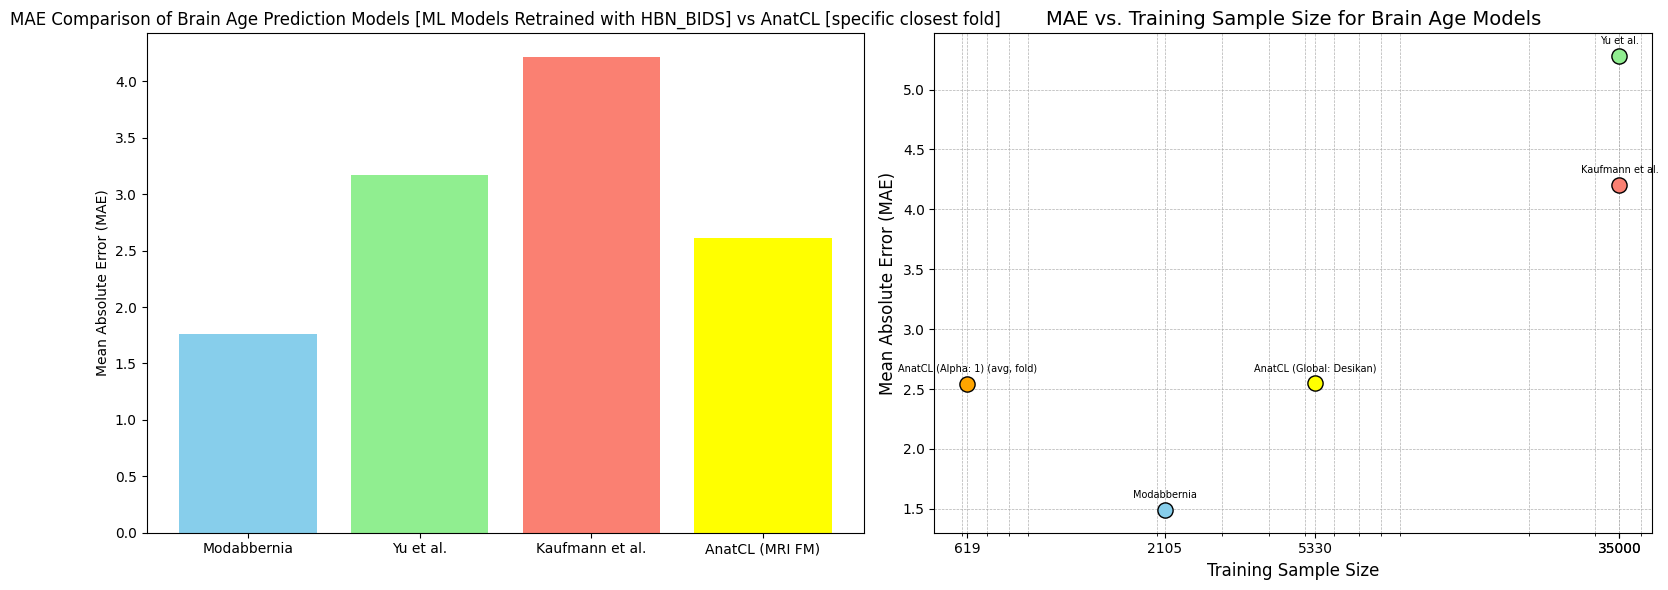

In [41]:
import os
import csv
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

base_dir = "/home/arelbaha/links/projects/rrg-glatard/arelbaha/hbn_bids"
subject_list_path = os.path.join(base_dir, "female_p_ages.txt")
jiya_file_path = os.path.join(base_dir, "combined_outputs_HBN.csv")
data = glob.glob(os.path.join(base_dir, "sub-*", "ses-*", "anat", "mri", "s6mwp1sub-*_T1w.nii"))

id_age_dict = {}
with open(subject_list_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            sid, age = parts
            sid = sid.replace("sub-", "")
            id_age_dict[sid] = float(age)

matched_subjects = []
matched_ages = []
for filepath in data:
    path_parts = filepath.split(os.sep)
    sub_folder = next((part for part in path_parts if part.startswith("sub-")), None)
    if sub_folder:
        subject_id = sub_folder.replace("sub-", "")
        if subject_id in id_age_dict:
            matched_subjects.append(subject_id)
            matched_ages.append(id_age_dict[subject_id])

print(f"Matched subjects with images and ages: {len(matched_subjects)}")

modabbernia_errors = []
yu_errors = []
kaufmann_errors = []

with open(jiya_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        csv_id = row[reader.fieldnames[0]].strip().replace("sub-", "")
        if csv_id in matched_subjects:
            try:
                modabbernia_errors.append(abs(float(row['adjerror_dev'])))
            except (ValueError, KeyError):
                pass
            try:
                yu_errors.append(abs(float(row['adjerror_global'])))
            except (ValueError, KeyError):
                pass
            try:
                kaufmann_errors.append(abs(float(row['kauffman_brainage_error'])))
            except (ValueError, KeyError):
                pass

print(f"Number of matched subjects in Jiya's CSV for Modabbernia: {len(modabbernia_errors)}")
print(f"Number of matched subjects in Jiya's CSV for Yu: {len(yu_errors)}")
print(f"Number of matched subjects in Jiya's CSV for Kaufmann: {len(kaufmann_errors)}")

def calc_mae(errors):
    return sum(errors) / len(errors) if errors else None

mae_modabbernia = calc_mae(modabbernia_errors)
mae_yu = calc_mae(yu_errors)
mae_kaufmann = calc_mae(kaufmann_errors)
mae_anatcl = 2.6149

print(f"MAE Modabbernia model: {mae_modabbernia}")
print(f"MAE Yu et al. model: {mae_yu}")
print(f"MAE Kaufmann et al. model: {mae_kaufmann}")
print(f"MAE Kaufmann et al. model: {mae_kaufmann} MAE: 2.6149 with 464 examples of Fold")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

models = ['Modabbernia', 'Yu et al.', 'Kaufmann et al.', 'AnatCL (MRI FM)']
mae_values = [mae_modabbernia, mae_yu, mae_kaufmann, mae_anatcl]
models_filtered = [m for m, v in zip(models, mae_values) if v is not None]
mae_filtered = [v for v in mae_values if v is not None]

ax1.bar(models_filtered, mae_filtered, color=['skyblue', 'lightgreen', 'salmon', 'yellow'])
ax1.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_title('MAE Comparison of Brain Age Prediction Models [ML Models Retrained with HBN_BIDS] vs AnatCL [specific closest fold]')

models_scatter = [
    (2105, 1.49, "Modabbernia", "skyblue"),
    (35000, 5.28, "Yu et al.", "lightgreen"),
    (35000, 4.2, "Kaufmann et al.", "salmon"),
    (5330, 2.55, "AnatCL (Global: Desikan)", "yellow"),
    (619, 2.5439, "AnatCL (Alpha: 1) (avg, fold)", "orange")
]

for size, mae, label, color in models_scatter:
    ax2.scatter(size, mae, label=label, color=color, s=120, edgecolor='black', zorder=3)
    ax2.text(size, mae + 0.1, label, ha='center', fontsize=7)

ax2.set_xscale('log')
sample_sizes = [m[0] for m in models_scatter]
ax2.set_xticks(sample_sizes)
ax2.get_xaxis().set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain', axis='x')
ax2.set_ylabel("Mean Absolute Error (MAE)", fontsize=12)
ax2.set_xlabel("Training Sample Size", fontsize=12)
ax2.set_title("MAE vs. Training Sample Size for Brain Age Models", fontsize=14)
ax2.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()